In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


# Prep training data

In [2]:
ds_training = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps.zarr", engine="zarr", chunks={}
) 
ds_training

<xarray.Dataset> Size: 36MB
Dimensions:   (time: 28, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 224B 0181-01-01 12:00:00 ... 0181-09-28 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 3MB dask.array<chunksize=(14, 82, 75), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>

In [3]:
ds_testing = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_testingData_southAtlantic_every10TimeSteps.zarr", engine="zarr", chunks={}
) 
ds_testing

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-10-08 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB dask.array<chunksize=(5, 82, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>

In [4]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_training['u_rel'].values
v_rel = ds_training['v_rel'].values
uv_math = np.cos(u_rel) + np.sin(v_rel) + u_rel * v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_math], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs


tensor([[[[-9.6512e-01, -6.3304e+00,  6.6317e+00],
          [-1.0361e+00, -6.3221e+00,  7.0210e+00],
          [-1.1081e+00, -6.3105e+00,  7.4117e+00],
          ...,
          [-6.0987e+00,  1.2395e+00, -5.6305e+00],
          [-6.1073e+00,  1.2843e+00, -5.8997e+00],
          [-6.1152e+00,  1.3286e+00, -6.1679e+00]],

         [[-9.2848e-01, -6.3078e+00,  6.4311e+00],
          [-9.9952e-01, -6.2975e+00,  6.8209e+00],
          [-1.0716e+00, -6.2841e+00,  7.2117e+00],
          ...,
          [-6.0868e+00,  1.2619e+00, -5.7475e+00],
          [-6.0947e+00,  1.3056e+00, -6.0099e+00],
          [-6.1019e+00,  1.3488e+00, -6.2711e+00]],

         [[-8.9164e-01, -6.2846e+00,  6.2303e+00],
          [-9.6266e-01, -6.2725e+00,  6.6203e+00],
          [-1.0347e+00, -6.2572e+00,  7.0112e+00],
          ...,
          [-6.0716e+00,  1.2825e+00, -5.8503e+00],
          [-6.0787e+00,  1.3250e+00, -6.1054e+00],
          [-6.0851e+00,  1.3670e+00, -6.3589e+00]],

         ...,

         [[-6.33

In [5]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_testing['u_rel'].values
v_rel = ds_testing['v_rel'].values
uv_math = np.cos(u_rel) + np.sin(v_rel) + u_rel * v_rel

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, uv_math], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs


tensor([[[[  3.0062,  -7.7230, -25.1991],
          [  2.9918,  -7.7252, -25.0930],
          [  2.9766,  -7.7257, -24.9744],
          ...,
          [  1.9640,  -2.9491,  -6.3664],
          [  1.9500,  -2.9161,  -6.2801],
          [  1.9346,  -2.8827,  -6.1889]],

         [[  2.9177,  -7.7081, -24.4542],
          [  2.9018,  -7.7083, -24.3286],
          [  2.8850,  -7.7069, -24.1909],
          ...,
          [  1.7906,  -2.8808,  -5.6343],
          [  1.7766,  -2.8462,  -5.5520],
          [  1.7613,  -2.8111,  -5.4651]],

         [[  2.8268,  -7.6902, -23.6757],
          [  2.8093,  -7.6885, -23.5311],
          [  2.7911,  -7.6853, -23.3751],
          ...,
          [  1.6157,  -2.8096,  -4.9102],
          [  1.6017,  -2.7734,  -4.8331],
          [  1.5865,  -2.7367,  -4.7515]],

         ...,

         [[ -9.3361,   1.2530, -11.7441],
          [ -9.3525,   1.2622, -11.8490],
          [ -9.3685,   1.2715, -11.9550],
          ...,
          [ -9.6673,   3.9525, -39.90

# Set up NN architecture

In [6]:
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, padding=1)  # Adjust input channels to 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_height // 8) * (image_width // 8), 128)  # Adjust for image dimensions = bring to correct dimension for pooling input size
        self.fc2 = nn.Linear(128, output_channels * image_height * image_width)  # Adjust output shape

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, output_channels, image_height, image_width)  # Reshape to output image
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)


In [8]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step
        
        # Assuming the shape is (x, y, vars), we need to split the last dimension
        # Let's say vars=6, then we extract the input images
        input_images = data[:, :, :2]  # Take the first 2 variables (assuming they are the images)

        # Load the corresponding target, assuming it's the next variable (var 7)
        target = data[:, :, 2]  # Replace with your actual target variable index

        return input_images, target  # Return input (6 images) and target


# Training NN

In [10]:
train_dataset = TensorDataset(training_NN_inputs)

# Set batch_size=1 for each time point to be its own batch
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

In [11]:
num_epochs = 500  # Number of epochs to train

In [12]:
loss_values = []

# Training loop

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [1, y, x, variables (6)]
        # targets shape: [1, y, x]

        # Note: Squeeze and unsqueeze to make model more generalizable (can skip if dims are exact)
        
        # Squeeze batch dimension (since batch_size=1)
        inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
        targets = targets.squeeze(0)  # Shape: (y, x)

        # Convert inputs to float32
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    
    # Store average loss in the list
    loss_values.append(average_loss)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete!")

Epoch [1/500], Loss: 242.3360
Epoch [2/500], Loss: 152.8756
Epoch [3/500], Loss: 129.2026
Epoch [4/500], Loss: 132.7211
Epoch [5/500], Loss: 125.3328
Epoch [6/500], Loss: 105.1705
Epoch [7/500], Loss: 113.8717
Epoch [8/500], Loss: 102.5729
Epoch [9/500], Loss: 77.4721
Epoch [10/500], Loss: 54.3727
Epoch [11/500], Loss: 46.9292
Epoch [12/500], Loss: 43.8140
Epoch [13/500], Loss: 53.2161
Epoch [14/500], Loss: 79.3048
Epoch [15/500], Loss: 110.2334
Epoch [16/500], Loss: 127.4347
Epoch [17/500], Loss: 87.2057
Epoch [18/500], Loss: 62.1084
Epoch [19/500], Loss: 44.5336
Epoch [20/500], Loss: 49.9139
Epoch [21/500], Loss: 42.7971
Epoch [22/500], Loss: 35.2188
Epoch [23/500], Loss: 33.0382
Epoch [24/500], Loss: 34.6516
Epoch [25/500], Loss: 32.4714
Epoch [26/500], Loss: 41.8776
Epoch [27/500], Loss: 27.0252
Epoch [28/500], Loss: 27.2882
Epoch [29/500], Loss: 24.7517
Epoch [30/500], Loss: 27.3232
Epoch [31/500], Loss: 28.9797
Epoch [32/500], Loss: 41.3969
Epoch [33/500], Loss: 18.9692
Epoch [34

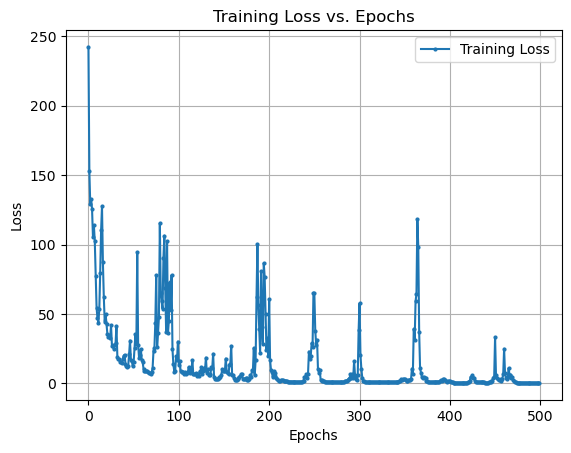

In [13]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing dataset

In [14]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

In [15]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


In [16]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

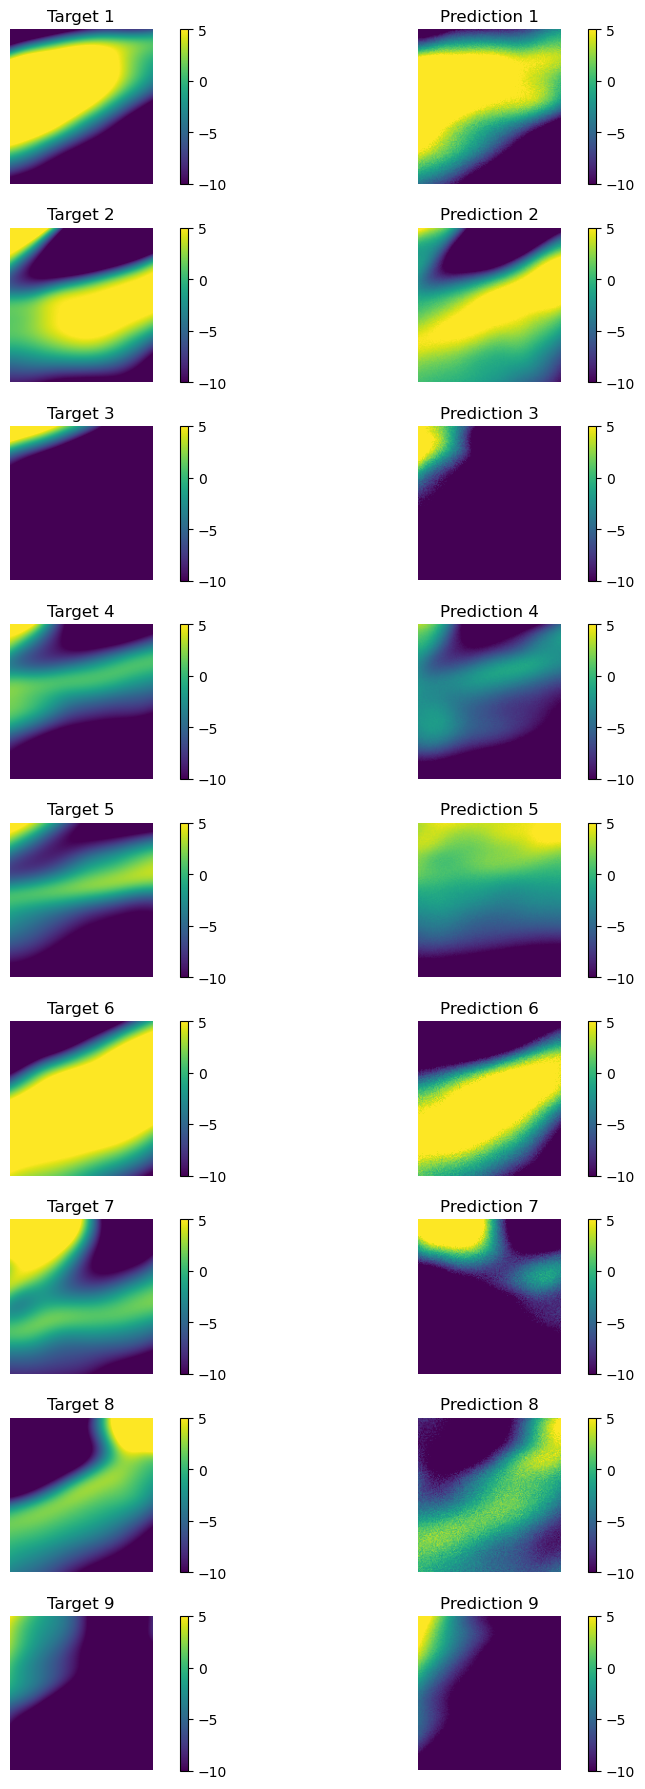

In [17]:
def plot_predictions_vs_targets(predictions, targets, num_samples=9):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=9)  # Change num_samples as needed


In [18]:
def calculate_rmse(predictions, targets):

    # Compute the squared differences
    squared_diff = (predictions - targets) ** 2
    
    # Calculate the mean of squared differences
    mean_squared_diff = squared_diff.mean(dim=(1, 2))  # Mean across height and width (assuming shape [batch, height, width])
    
    # Calculate RMSE by taking the square root
    rmse = torch.sqrt(mean_squared_diff)  # Shape will be (batch_size,)
    
    return rmse

# Assuming predictions and targets are your outputs from the evaluation function
rmse_values = calculate_rmse(predictions, targets)

# List to store individual RMSE values
individual_rmse_values = []

# Print RMSE for each prediction-target pair
for i in range(0, predictions.shape[0]):
    rmse_value = calculate_rmse(predictions[i], targets[i])
    individual_rmse_values.append(rmse_value.item())  # Store the RMSE for plotting
    print(f"RMSE for prediction-target pair {i + 1}: {rmse_value.item():.4f}")


RMSE for prediction-target pair 1: 5.5432
RMSE for prediction-target pair 2: 5.9520
RMSE for prediction-target pair 3: 13.0200
RMSE for prediction-target pair 4: 4.2825
RMSE for prediction-target pair 5: 6.1538
RMSE for prediction-target pair 6: 7.4112
RMSE for prediction-target pair 7: 14.1574
RMSE for prediction-target pair 8: 5.6009
RMSE for prediction-target pair 9: 5.2008


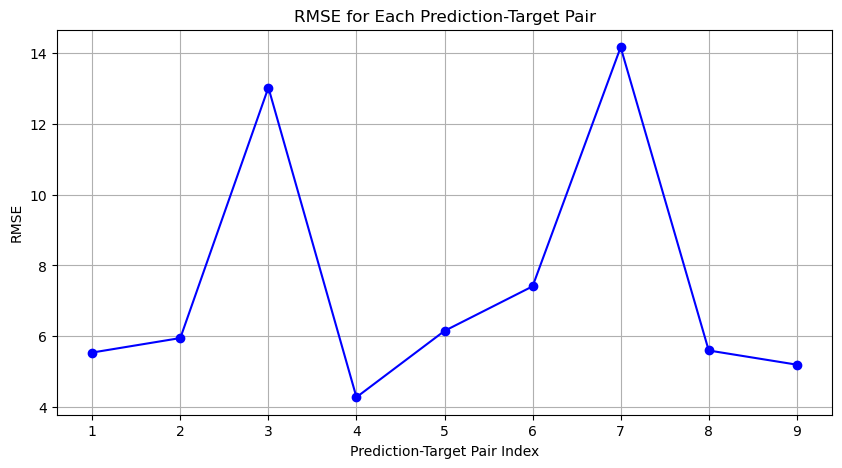

In [19]:
# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(individual_rmse_values) + 1), individual_rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE for Each Prediction-Target Pair')
plt.xlabel('Prediction-Target Pair Index')
plt.ylabel('RMSE')
plt.xticks(range(1, len(individual_rmse_values) + 1))  # Set x-ticks to match the number of pairs
plt.grid(True)
plt.show()

#### Exploring saved datasets for future work

In [20]:
import fsspec
fs = fsspec.filesystem('gs') # equivalent to gcsfs.GCSFileSystem()
fs.ls("leap-persistent/panalluri")


['leap-persistent/panalluri/FF_HR.zarr',
 'leap-persistent/panalluri/FF_iceMask.zarr',
 'leap-persistent/panalluri/FF_spatialAvg_weighted_iceMask.zarr',
 'leap-persistent/panalluri/HF_highRes.zarr',
 'leap-persistent/panalluri/HF_iceMask.zarr',
 'leap-persistent/panalluri/HF_lowRes.zarr',
 'leap-persistent/panalluri/HF_spatialAvg_weighted_iceMask.zarr',
 'leap-persistent/panalluri/HF_star.zarr',
 'leap-persistent/panalluri/MF_spatialAvg_weighted.zarr',
 'leap-persistent/panalluri/MF_spatialAvg_weighted_iceMask.zarr',
 'leap-persistent/panalluri/ds_testingData_southAtlantic.zarr',
 'leap-persistent/panalluri/ds_testingData_southAtlantic_every10TimeSteps.zarr',
 'leap-persistent/panalluri/ds_trainingData_southAtlantic.zarr',
 'leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps.zarr',
 'leap-persistent/panalluri/momFluxHR.zarr',
 'leap-persistent/panalluri/momFluxHR_iceMask.zarr']